In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from __future__ import division

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier


In [3]:
data_dir = 'data/'

In [4]:
draft = pd.read_csv(data_dir + 'draft_clean.csv', sep = '\t', index_col = 0)
ncaa = pd.read_csv(data_dir + 'ncaa_players_clean.csv', sep = '\t', index_col = 0)
ncaa_division = pd.read_csv(data_dir + 'ncaa_divisions.csv')

In [5]:
draft['dummy'] = 1
print draft.head()
print draft.describe()


               namekeys                 Player  Year  Rd  Pk   Tm  dummy
0          masonplumlee          Mason Plumlee  2013   1  22  BRK      1
1            rudygobert            Rudy Gobert  2013   1  27  DEN      1
2           stevenadams           Steven Adams  2013   1  12  OKC      1
3  giannisantetokounmpo  Giannis Antetokounmpo  2013   1  15  MIL      1
4            codyzeller            Cody Zeller  2013   1   4  CHA      1
              Year          Rd          Pk  dummy
count   180.000000  180.000000  180.000000    180
mean   2014.000000    1.500000   30.500000      1
std       0.818774    0.501395   17.366409      0
min    2013.000000    1.000000    1.000000      1
25%    2013.000000    1.000000   15.750000      1
50%    2014.000000    1.500000   30.500000      1
75%    2015.000000    2.000000   45.250000      1
max    2015.000000    2.000000   60.000000      1


In [6]:
divs_only = ncaa_division[['school_id','year','Division']]
ncaa_divs = pd.merge(ncaa, divs_only, how = 'left', on = ['school_id','year'])

ncaa_divs.head()

,school_name,school_id,year,name,player_id,class_year,season,position,height,games,...,blocks,blocks_per_game,steals,steals_per_game,points,points_per_game,turnovers,turnovers_per_game,namekeys,Division
0,A&M-Corpus Christi,26172,2013,Hameed Ali,1289295,So.,2012-13,G,6-2,29,...,5,0.172,42,1.448,218,7.517,35,1.206897,hameedali,1
1,A&M-Corpus Christi,26172,2013,Jelani Currie,1402236,Fr.,2012-13,G,6-4,18,...,2,0.111,0,0.000,32,1.778,14,0.777778,jelanicurrie,1
2,A&M-Corpus Christi,26172,2013,Kennon Dvorak,1289297,Jr.,2012-13,G,6-2,13,...,0,0.000,2,0.154,14,1.077,6,0.461538,kennondvorak,1
3,A&M-Corpus Christi,26172,2013,Dale Francis,1402237,Fr.,2012-13,F,6-9,29,...,7,0.241,8,0.276,58,2.000,21,0.724138,dalefrancis,1
4,A&M-Corpus Christi,26172,2013,Johnathan Jordan,1289299,So.,2012-13,G,5-10,29,...,5,0.172,39,1.345,372,12.828,82,2.827586,johnathanjordan,1


In [7]:
ncaa_draft = pd.merge(ncaa_divs, draft, how = 'left', on = 'namekeys')

In [8]:
ncaa_draft['dummy'].fillna(0, inplace = True)
ncaa_draft['eFG'] = (ncaa_draft['field_goals'] + (0.5 * ncaa_draft['three_pointers']))/ ncaa_draft['field_goal_attempts']
ncaa_draft['eFG'].fillna(0, inplace = True)
ncaa_draft['turnovers_per_game'].fillna(0,inplace = True)
ncaa_draft['AST/TO'] = ncaa_draft['assists']/ncaa_draft['turnovers']
ncaa_draft['AST/TO'].replace([np.inf, -np.inf], np.nan, inplace = True)
ncaa_draft['AST/TO'].fillna(0, inplace = True)
ncaa_draft = pd.get_dummies(ncaa_draft, columns = ['Division'], prefix = 'is_Div')


In [9]:
ncaa_draft_dd = ncaa_draft.drop_duplicates(subset = ['namekeys'], keep = 'last')
height = pd.DataFrame(list(ncaa_draft_dd.height.str.split('-')))
height.columns = ['foot','inch']
height[['foot','inch']] = height[['foot','inch']].replace('',0)
height[['foot','inch']] = height[['foot','inch']].astype(int)
height['foot'] = height['foot'] * [12]
height['total_height'] = height['foot'] + height['inch']
height.head()
ncaa_draft_dd = ncaa_draft_dd.reset_index()
ncaa_draft_dd = ncaa_draft_dd.drop('index', 1)

In [10]:
ncaa_draft_dd = ncaa_draft_dd.join(height['total_height'])

In [11]:
drafted = ncaa_draft_dd[ncaa_draft_dd.dummy == 1]
undrafted = ncaa_draft_dd[ncaa_draft_dd.dummy == 0]
draft_train = drafted.loc[np.random.choice(drafted.index, 137, replace=False)]
undraft_train = undrafted.loc[np.random.choice(undrafted.index, (137*10), replace = False)]

In [12]:
frames = [draft_train, undraft_train]
ncaa_bal = pd.concat(frames) 
ncaa_bal.head()

,school_name,school_id,year,name,player_id,class_year,season,position,height,games,...,Rd,Pk,Tm,dummy,eFG,AST/TO,is_Div_1.0,is_Div_2.0,is_Div_3.0,total_height
12513,Washington,756,2014,C.J. Wilcox,1070496,Sr.,2013-14,G,6-5,32,...,1,28,LAC,1,0.556322,1.500000,1,0,0,77
209,Arizona,29,2013,Solomon Hill,1064640,Sr.,2012-13,F,6-7,35,...,1,23,IND,1,0.540580,1.233766,1,0,0,79
20878,LSU,365,2015,Jordan Mickey,1519698,So.,2014-15,F,6-8,25,...,2,33,BOS,1,0.523585,0.404762,1,0,0,80
11679,Stanford,674,2014,Dwight Powell,1176135,Sr.,2013-14,F,6-10,36,...,2,45,CHH,1,0.474934,1.076923,1,0,0,82
9163,Louisville,367,2014,Russ Smith,1177525,Sr.,2013-14,G,6-0,37,...,2,47,PHI,1,0.540541,1.638095,1,0,0,72


In [13]:
X_cols = ['field_goals', 'field_goal_attempts', 'field_goal_percent',
          'three_pointers', 'three_pointer_attempts', 'three_pointer_percent',
          'free_throws', 'free_throw_attempts', 'free_throw_percent',
          'rebounds', 'rebounds_per_game', 'assists', 'assists_per_game',
          'blocks', 'blocks_per_game', 'steals', 'steals_per_game', 'points',
          'points_per_game', 'turnovers', 'turnovers_per_game',
          'eFG', 'AST/TO','total_height','is_Div_1.0','is_Div_2.0']


features = ['field_goal_percent','three_pointer_percent', 'eFG','free_throw_percent','rebounds_per_game','total_height',
            'assists_per_game','AST/TO', 'blocks_per_game','steals_per_game','points_per_game','turnovers_per_game',
            'is_Div_1.0','is_Div_2.0']


In [32]:
X_scaled = StandardScaler().fit_transform(ncaa_bal[features])
X = ncaa_bal[features]
y = ncaa_bal['dummy']

X_t, X_tt, y_t, y_tt = cross_validation.train_test_split(X,y, test_size = .2)
X_ts, X_tts, y_ts, y_tts = cross_validation.train_test_split(X_scaled, y, test_size = .2)

X_all_scaled = StandardScaler().fit_transform(ncaa_draft_dd[features])
X_all = ncaa_draft_dd[features]
y_all = ncaa_draft_dd['dummy']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, test_size = .2)
X_train_s, X_test_s, y_train_s, y_test_s = cross_validation.train_test_split(X_all_scaled, y_all, test_size = .2)



In [33]:
forest = RandomForestClassifier(n_estimators=250, max_features = 'auto',
                                random_state=0, max_depth=None,
                                oob_score= True,
                                class_weight = {0:1, 1:10})
forest.fit(X_t, y_t)
scores = cross_validation.cross_val_score(forest, X_t, y_t)
print "RandomForestClassifier:", scores.mean()
print "RandomForestClassifier CM:"
print metrics.confusion_matrix(y_tt, forest.predict(X_tt))
print metrics.classification_report(y_tt, forest.predict(X_tt))
gbc = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 250,
                                max_depth = 100, max_features = 'auto',
                                random_state = 0)
gbc.fit(X_t,y_t)
scores = cross_validation.cross_val_score(gbc, X_t, y_t)
print "GradientBoostingClassifier:", scores.mean()
print "GradientBoostingClassifier CM:"
print metrics.confusion_matrix(y_tt, gbc.predict(X_tt))
print metrics.classification_report(y_tt, gbc.predict(X_tt))

ada = AdaBoostClassifier(n_estimators = 250, learning_rate = 0.05, random_state = 0)
ada.fit(X_t,y_t)
scores = cross_validation.cross_val_score(ada, X_t, y_t)
print "AdaBoostClassifier:", scores.mean()
print "AdaBoostClassifier CM:"
print metrics.confusion_matrix(y_tt, ada.predict(X_tt))
print metrics.classification_report(y_tt, ada.predict(X_tt))

forests = RandomForestClassifier(n_estimators=250, max_features = 'auto',
                                random_state=0, max_depth=None,
                                oob_score= True,
                                class_weight = {0:1, 1:10})
forests.fit(X_ts, y_ts)
scores = cross_validation.cross_val_score(forests, X_ts, y_ts)
print "RandomForestClassifier:", scores.mean()
print "RandomForestClassifier (scaled) CM:"
print metrics.confusion_matrix(y_tts, forests.predict(X_tts))
print metrics.classification_report(y_tts, forests.predict(X_tts))

gbcs = GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 250,
                                max_depth = 100, max_features = 'auto',
                                random_state = 0)
gbcs.fit(X_ts,y_ts)
scores = cross_validation.cross_val_score(gbcs, X_ts, y_ts)
print "GradientBoostingClassifier:", scores.mean()
print "GradientBoostingClassifier (scaled) CM:"
print metrics.confusion_matrix(y_tts, gbcs.predict(X_tts))
print metrics.classification_report(y_tts, gbcs.predict(X_tts))

adas = AdaBoostClassifier(n_estimators = 250, learning_rate = 0.05, random_state = 0)
adas.fit(X_ts,y_ts)
scores = cross_validation.cross_val_score(adas, X_ts, y_ts)
print "AdaBoostClassifier:", scores.mean()
print "AdaBoostClassifier (scaled) CM:"
print metrics.confusion_matrix(y_tts, adas.predict(X_tts))
print metrics.classification_report(y_tts, adas.predict(X_tts))

RandomForestClassifier: 0.943571833269
RandomForestClassifier CM:
[[261   9]
 [ 10  22]]
             precision    recall  f1-score   support

        0.0       0.96      0.97      0.96       270
        1.0       0.71      0.69      0.70        32

avg / total       0.94      0.94      0.94       302

GradientBoostingClassifier: 0.946894786252
GradientBoostingClassifier CM:
[[259  11]
 [ 11  21]]
             precision    recall  f1-score   support

        0.0       0.96      0.96      0.96       270
        1.0       0.66      0.66      0.66        32

avg / total       0.93      0.93      0.93       302

AdaBoostClassifier: 0.951038655434
AdaBoostClassifier CM:
[[265   5]
 [ 11  21]]
             precision    recall  f1-score   support

        0.0       0.96      0.98      0.97       270
        1.0       0.81      0.66      0.72        32

avg / total       0.94      0.95      0.94       302

RandomForestClassifier: 0.944380157959
RandomForestClassifier (scaled) CM:
[[276   4]
 [

In [35]:
print "RandomForestClassifier CM:"
print metrics.confusion_matrix(y_all, forest.predict(X_all))
print metrics.classification_report(y_all, forest.predict(X_all))

print "GradientBoostingClassifier CM:"
print metrics.confusion_matrix(y_all, gbc.predict(X_all))
print metrics.classification_report(y_all, gbc.predict(X_all))

print "AdaBoostClassifier CM:"
print metrics.confusion_matrix(y_all, ada.predict(X_all))
print metrics.classification_report(y_all, ada.predict(X_all))


print "RandomForestClassifier (scaled) CM:"
print metrics.confusion_matrix(y_all, forests.predict(X_all_scaled))
print metrics.classification_report(y_all, forests.predict(X_all_scaled))

print "GradientBoostingClassifier (scaled) CM:"
print metrics.confusion_matrix(y_all, gbcs.predict(X_all_scaled))
print metrics.classification_report(y_all, gbcs.predict(X_all_scaled))

print "AdaBoostClassifier (scaled) CM:"
print metrics.confusion_matrix(y_all, adas.predict(X_all_scaled))
print metrics.classification_report(y_all, adas.predict(X_all_scaled))

RandomForestClassifier CM:
[[29556   628]
 [   13   124]]
             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99     30184
        1.0       0.16      0.91      0.28       137

avg / total       1.00      0.98      0.99     30321

GradientBoostingClassifier CM:
[[29501   683]
 [   15   122]]
             precision    recall  f1-score   support

        0.0       1.00      0.98      0.99     30184
        1.0       0.15      0.89      0.26       137

avg / total       1.00      0.98      0.99     30321

AdaBoostClassifier CM:
[[29734   450]
 [   36   101]]
             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99     30184
        1.0       0.18      0.74      0.29       137

avg / total       1.00      0.98      0.99     30321

RandomForestClassifier (scaled) CM:
[[29236   948]
 [   16   121]]
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.98     30184
       

In [86]:
importances = forest.fit(X_t, y_t).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
df = pd.DataFrame(features, importances)
df = df.reset_index()
df.columns = ['importances', 'features']
print df.sort_values(by = 'importances', ascending = False)

    importances               features
10     0.215173        points_per_game
12     0.209589             is_Div_1.0
4      0.096748      rebounds_per_game
11     0.085184     turnovers_per_game
5      0.062407           total_height
9      0.056356        steals_per_game
0      0.052482     field_goal_percent
8      0.051450        blocks_per_game
6      0.050390       assists_per_game
2      0.033500                    eFG
13     0.028264             is_Div_2.0
3      0.026868     free_throw_percent
7      0.019000                 AST/TO
1      0.012589  three_pointer_percent


In [87]:
importances = gbc.fit(X_t, y_t).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
df = pd.DataFrame(features, importances)
df = df.reset_index()
df.columns = ['importances', 'features']
print df.sort_values(by = 'importances', ascending = False)

    importances               features
10     0.213378        points_per_game
4      0.118450      rebounds_per_game
12     0.112257             is_Div_1.0
8      0.085346        blocks_per_game
6      0.081463       assists_per_game
11     0.064486     turnovers_per_game
9      0.061271        steals_per_game
5      0.058097           total_height
2      0.052916                    eFG
3      0.039073     free_throw_percent
0      0.036584     field_goal_percent
7      0.034468                 AST/TO
1      0.028112  three_pointer_percent
13     0.014099             is_Div_2.0


In [88]:
importances = ada.fit(X_t, y_t).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

df = pd.DataFrame(features, importances)
df = df.reset_index()
df.columns = ['importances', 'features']
print df.sort_values(by = 'importances', ascending = False)

    importances               features
10        0.236        points_per_game
4         0.184      rebounds_per_game
5         0.132           total_height
12        0.132             is_Div_1.0
2         0.076                    eFG
6         0.072       assists_per_game
0         0.044     field_goal_percent
8         0.044        blocks_per_game
9         0.036        steals_per_game
13        0.032             is_Div_2.0
3         0.012     free_throw_percent
1         0.000  three_pointer_percent
7         0.000                 AST/TO
11        0.000     turnovers_per_game


In [89]:
print "RandomForestClassifier CM:"
print metrics.confusion_matrix(y_all, forest.predict(X_all))
print metrics.classification_report(y_all, forest.predict(X_all))

print "GradientBoostingClassifier CM:"
print metrics.confusion_matrix(y_all, gbc.predict(X_all))
print metrics.classification_report(y_all, gbc.predict(X_all))

print "AdaBoostClassifier CM:"
print metrics.confusion_matrix(y_all, ada.predict(X_all))
print metrics.classification_report(y_all, ada.predict(X_all))

RandomForestClassifier CM:
[[29398   786]
 [    8   129]]
             precision    recall  f1-score   support

        0.0       1.00      0.97      0.99     30184
        1.0       0.14      0.94      0.25       137

avg / total       1.00      0.97      0.98     30321

GradientBoostingClassifier CM:
[[29750   434]
 [   10   127]]
             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99     30184
        1.0       0.23      0.93      0.36       137

avg / total       1.00      0.99      0.99     30321

AdaBoostClassifier CM:
[[29776   408]
 [   47    90]]
             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99     30184
        1.0       0.18      0.66      0.28       137

avg / total       0.99      0.98      0.99     30321



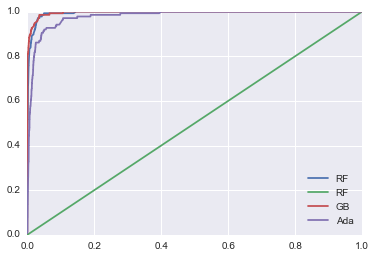

In [90]:
fpr, tpr, thresholds = metrics.roc_curve(y_all, forest.predict_proba(X_all)[:,1])
forest_plt = plt.plot(fpr, tpr, fpr, fpr, label = 'RF') # Second x,y pairs here are just to plot a line with slop 1.

fpr, tpr, thresholds = metrics.roc_curve(y_all, gbc.predict_proba(X_all)[:,1])
gbc_plt = plt.plot(fpr, tpr, label = 'GB') # Second x,y pairs here are just to plot a line with slop 1.

fpr, tpr, thresholds = metrics.roc_curve(y_all, ada.predict_proba(X_all)[:,1])
ada_plt = plt.plot(fpr, tpr, label = 'Ada') # Second x,y pairs here are just to plot a line with slop 1.

plt.legend(loc='lower right')


In [94]:
logm = linear_model.LogisticRegression()
logm.fit(X_t, y_t)

<bound method LogisticRegression.score of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)>


In [99]:
print logm.coef_
print logm.score(X,y)

[[-0.47325196  0.17408684 -0.40304541 -0.8466602   0.29016289 -0.03092199
   1.01832836 -1.0918553   0.93860004 -0.06755667  0.27163405 -1.5231906
   2.72047025 -1.10477584]]
0.949568679496


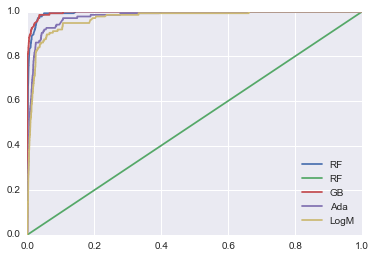

In [100]:
fpr, tpr, thresholds = metrics.roc_curve(y_all, forest.predict_proba(X_all)[:,1])
forest_plt = plt.plot(fpr, tpr, fpr, fpr, label = 'RF') # Second x,y pairs here are just to plot a line with slop 1.

fpr, tpr, thresholds = metrics.roc_curve(y_all, gbc.predict_proba(X_all)[:,1])
gbc_plt = plt.plot(fpr, tpr, label = 'GB') # Second x,y pairs here are just to plot a line with slop 1.

fpr, tpr, thresholds = metrics.roc_curve(y_all, ada.predict_proba(X_all)[:,1])
ada_plt = plt.plot(fpr, tpr, label = 'Ada') # Second x,y pairs here are just to plot a line with slop 1.

fpr, tpr, thresholds = metrics.roc_curve(y_all, logm.predict_proba(X_all)[:,1])
logm_plt = plt.plot(fpr, tpr, label = 'LogM') # Second x,y pairs here are just to plot a line with slop 1.


plt.legend(loc='lower right')